In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [2]:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
transaction = pd.read_csv('trans_new.csv')

In [4]:
transaction = transaction.drop(transaction.columns[0], axis = 1)
transaction.head()

,id,chain,dept,category,company,brand,date,productsize,productmeasure,purchasequantity,purchaseamount
0,696521494,211,55,5558,101111010,9907,2013-01-23,36.0,OZ,1,2.99
1,417112954,100,63,6320,107509070,182,2012-12-09,12.0,CT,1,2.29
2,308340717,360,35,3504,103500030,13470,2012-06-12,10.0,OZ,1,1.79
3,4629335121,153,63,6320,1068826767,81691,2012-09-10,12.0,CT,1,2.79
4,743051948,58,63,6330,101111010,9907,2012-10-07,16.0,OZ,1,2.79


In [5]:
def missing_count(dataset):
    missing = {}
    for col in dataset.columns:
        missing[col] = len(dataset[dataset[col].isnull()])
    return missing

In [6]:
missing_count(transaction)

{'brand': 0,
 'category': 0,
 'chain': 0,
 'company': 0,
 'date': 0,
 'dept': 0,
 'id': 0,
 'productmeasure': 14441,
 'productsize': 0,
 'purchaseamount': 0,
 'purchasequantity': 0}

In [7]:
len(set(transaction['chain']))   # 132 chain stores

132

In [8]:
len(transaction.groupby(['category','company','brand','productsize','productmeasure']))
# 58053 different types of goods

58053

In [9]:
len(set(transaction['id']))  # 193779 different customers

193779

In [10]:
transaction.shape[0]   # 450,252 transactions

450252

In [11]:
len(set(transaction['category']))   # 804 categories

804

In [12]:
len(set(transaction['company']))   # 9463 companies

9463

In [13]:
len(transaction.loc[(transaction['productmeasure'].isnull()) & (transaction['productsize'] != 0.0)]) 

0

### This shows all records with null measures of product are associated with 0.0 product size, indicating either a product return or change. I then fill all the null values of product measure with 'Unknown'.

In [14]:
transaction['productmeasure'].value_counts()

OZ    367298
CT     54246
RL      5634
LB      5122
LT      3352
YD       156
FT         2
1          1
Name: productmeasure, dtype: int64

In [15]:
transaction.loc[transaction[transaction['productmeasure'] == 1].index, 'productmeasure'] = 'oz' 

In [16]:
transaction['productmeasure'].fillna('Unknown', inplace = True)

### I also add a feature 'price' indicating the price of the product in the transaction, which is calculated as amount purchased in the transaction divided by quantity purchased in the transaction. For returns or changes, the price is None.

In [17]:
transaction['price'] = transaction.apply(lambda x: x.purchaseamount/x.purchasequantity if (x.purchaseamount > 0 and x.purchasequantity > 0) else None, axis = 1)

In [18]:
len(transaction[(transaction['purchaseamount'] <= 0) | (transaction['purchasequantity'] <= 0)])

17224

In [19]:
float(17224) / 450252 * 100   # 3.8% 

3.8254133240940633

### This shows out of 450,252 transactions, there are 17,224 transactions are either returns or changes, which counts for 3.8% of the total transactions.

In [20]:
transaction['price'].describe()

count    433028.000000
mean          3.498594
std           4.932820
min           0.004264
25%           1.790000
50%           2.790000
75%           3.990000
max        1623.550000
Name: price, dtype: float64

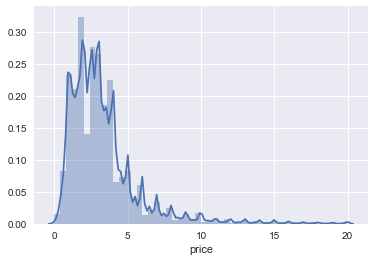

In [21]:
sns.distplot(transaction[transaction['price'] < 20].price)

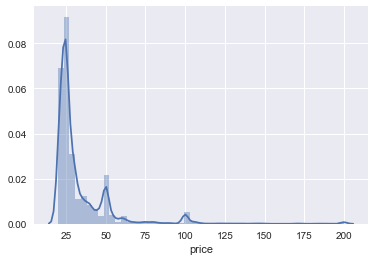

In [22]:
sns.distplot(transaction[(transaction['price'] >= 20) & (transaction['price'] <= 200)].price)

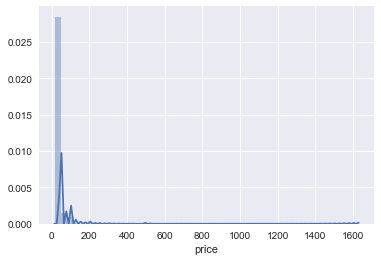

In [23]:
sns.distplot(transaction[transaction['price'] >= 20].price)

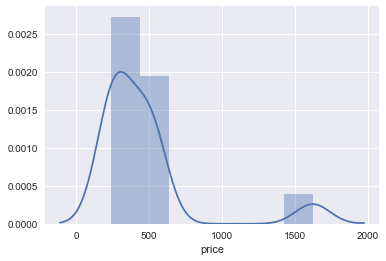

In [24]:
sns.distplot(transaction[transaction['price'] > 200].price)

### Take a look at quantity purchased.

In [25]:
transaction['purchasequantity'].describe()

count    450252.000000
mean          1.610749
std           6.388980
min         -33.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        1742.000000
Name: purchasequantity, dtype: float64

In [26]:
transaction[transaction['purchasequantity']>0].purchasequantity.describe()

count    449189.000000
mean          1.615937
std           6.395241
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        1742.000000
Name: purchasequantity, dtype: float64

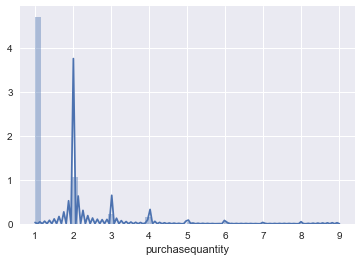

In [27]:
sns.distplot(transaction[(transaction['purchasequantity'] < 10) & (transaction['purchasequantity'] > 0)].purchasequantity)   
## an important graph showing the majority of price distribution

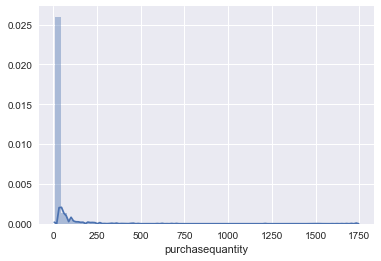

In [28]:
sns.distplot(transaction[transaction['purchasequantity'] >= 10].purchasequantity)   

### I now extract year and month information from the data.

In [29]:
transaction['date'] = transaction['date'].apply(lambda x: pd.to_datetime(x))

In [30]:
transaction['year'] = transaction['date'].dt.year
transaction['month'] = transaction['date'].dt.month

In [31]:
transaction['date'].value_counts()

2013-02-02    1942
2012-12-22    1936
2012-12-23    1920
2012-11-18    1780
2012-10-27    1743
2013-03-03    1720
2012-12-02    1704
2012-11-17    1702
2012-11-21    1698
2012-12-16    1697
2013-02-03    1669
2013-01-13    1654
2013-01-06    1644
2013-01-27    1635
2012-04-07    1621
2012-12-09    1618
2013-01-26    1616
2012-10-28    1610
2013-01-19    1609
2012-12-15    1603
2013-01-05    1599
2013-03-10    1590
2013-01-12    1587
2013-03-02    1583
2012-09-23    1582
2012-11-04    1578
2013-03-24    1576
2012-11-11    1576
2013-03-17    1576
2013-03-09    1574
              ... 
2012-04-26     861
2012-04-25     859
2012-05-30     859
2012-04-11     857
2012-04-09     857
2012-03-08     857
2012-07-18     855
2012-03-12     855
2012-03-27     851
2012-09-25     847
2012-08-28     845
2012-05-08     842
2012-03-14     839
2012-04-10     839
2012-03-06     836
2012-04-17     828
2013-03-27     827
2012-11-23     818
2012-03-28     812
2012-03-21     809
2012-03-13     807
2012-10-30  

### We notice in particular on 2012-12-25 (Christmas), the number of transaction is particularly small, followed by 2012-11-22 (Thanksgiving). This is due to many stores close on that day. But we also notice 2012-12-22, 2012-12-23 and 2012-11-18 have huge sales, maybe because of the holidy reason. 

In [32]:
transaction['date'].sort_values(ascending = True)

118782   2012-03-02
194257   2012-03-02
265290   2012-03-02
394479   2012-03-02
133203   2012-03-02
103710   2012-03-02
200574   2012-03-02
268410   2012-03-02
121603   2012-03-02
74885    2012-03-02
444637   2012-03-02
200545   2012-03-02
367122   2012-03-02
271614   2012-03-02
13694    2012-03-02
394469   2012-03-02
402110   2012-03-02
387587   2012-03-02
387580   2012-03-02
392384   2012-03-02
380248   2012-03-02
200700   2012-03-02
380387   2012-03-02
164258   2012-03-02
103762   2012-03-02
234816   2012-03-02
318012   2012-03-02
21385    2012-03-02
130312   2012-03-02
433952   2012-03-02
            ...    
155853   2013-03-31
144532   2013-03-31
132040   2013-03-31
347383   2013-03-31
278096   2013-03-31
228250   2013-03-31
228280   2013-03-31
155183   2013-03-31
155185   2013-03-31
416505   2013-03-31
448876   2013-03-31
409509   2013-03-31
186657   2013-03-31
160497   2013-03-31
208347   2013-03-31
9432     2013-03-31
347076   2013-03-31
406629   2013-03-31
310502   2013-03-31


### We see that the dates range from the beginning of March 2012 to the end of March 2013.

### I want to build date block for each transaction, that is, transactions in the same month will be grouped in the same date block. For example, transactions in March 2012 belongs to date block 'lag_12', transactions in April 2012 belongs to date block'lag_11',..., transactions in March 2013 belongs to date block'lag_0', which is the current month.

In [33]:
transaction['dateblock'] = transaction.apply(lambda x: "lag_{}".format(3 - x.month) if x.year == 2013 else "lag_{}".format(15 - x.month), axis = 1)

In [34]:
transaction_counts = pd.DataFrame({'Count': transaction['dateblock'].value_counts().sort_values(ascending = False)})

In [35]:
transaction_counts

,Count
lag_3,39256
lag_2,37509
lag_4,36936
lag_0,36199
lag_5,35460
lag_1,34940
lag_6,34673
lag_7,34089
lag_8,33356
lag_10,33143


In [36]:
transaction_counts= transaction_counts.reindex_axis([u'lag_0', u'lag_1', u'lag_2', u'lag_3', u'lag_4', u'lag_5',
       u'lag_6', u'lag_7', u'lag_8', u'lag_9', u'lag_10', u'lag_11', u'lag_12'], axis = 0)

In [37]:
transaction_counts

,Count
lag_0,36199
lag_1,34940
lag_2,37509
lag_3,39256
lag_4,36936
lag_5,35460
lag_6,34673
lag_7,34089
lag_8,33356
lag_9,32554


Text(0.5,1,u'Number of transaction in each dateblock/month')

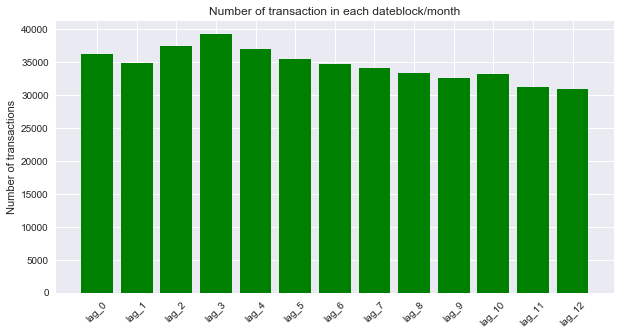

In [38]:
plt.figure(figsize = (10, 5))
plt.bar(np.arange(len(transaction_counts)), transaction_counts.Count, color = 'green')
plt.xticks(np.arange(len(transaction_counts)), transaction_counts.index, rotation = 45)
plt.ylabel("Number of transactions")
plt.title("Number of transaction in each dateblock/month")

### Now I want to restrict the data to the data that has positive price. So I ignore transactions that are either returns or changes.

In [39]:
transaction = transaction.dropna(subset = ['price'])

In [40]:
len(transaction)   # 433028 valid transactions out of 450252 transactions.

433028

In [41]:
ave_quantity_block = transaction.groupby(['dateblock']).purchasequantity.mean()
ave_amount_block = transaction.groupby(['dateblock']).purchaseamount.mean()

In [42]:
ave_quantity_block

dateblock
lag_0     1.623877
lag_1     1.612330
lag_10    1.614391
lag_11    1.684356
lag_12    1.612943
lag_2     1.626208
lag_3     1.688698
lag_4     1.635062
lag_5     1.578581
lag_6     1.631277
lag_7     1.574484
lag_8     1.618326
lag_9     1.588150
Name: purchasequantity, dtype: float64

In [43]:
ave_quantity_block= ave_quantity_block.reindex_axis([u'lag_0', u'lag_1', u'lag_2', u'lag_3', u'lag_4', u'lag_5',
       u'lag_6', u'lag_7', u'lag_8', u'lag_9', u'lag_10', u'lag_11', u'lag_12'], axis = 0)

In [44]:
ave_quantity_block

dateblock
lag_0     1.623877
lag_1     1.612330
lag_2     1.626208
lag_3     1.688698
lag_4     1.635062
lag_5     1.578581
lag_6     1.631277
lag_7     1.574484
lag_8     1.618326
lag_9     1.588150
lag_10    1.614391
lag_11    1.684356
lag_12    1.612943
Name: purchasequantity, dtype: float64

In [45]:
ave_amount_block= ave_amount_block.reindex_axis([u'lag_0', u'lag_1', u'lag_2', u'lag_3', u'lag_4', u'lag_5',
       u'lag_6', u'lag_7', u'lag_8', u'lag_9', u'lag_10', u'lag_11', u'lag_12'], axis = 0)

Text(0.5,1,u'Average quantity purchased per transaction')

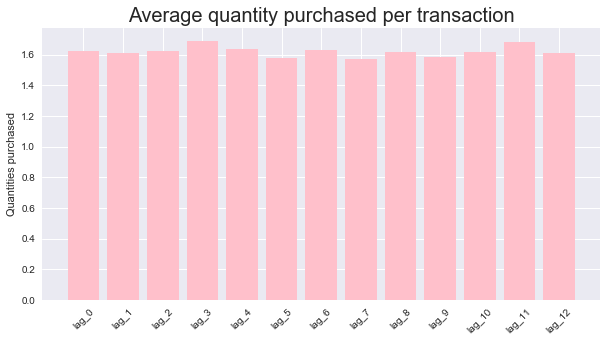

In [46]:
plt.figure(figsize = (10, 5))
plt.bar(np.arange(len(ave_quantity_block)),ave_quantity_block.values, color = 'pink')
plt.xticks(np.arange(len(ave_quantity_block)),ave_quantity_block.index, rotation = 45)
plt.ylabel('Quantities purchased')
plt.title('Average quantity purchased per transaction', fontsize = 20)

Text(0.5,1,u'Average amount purchased per transaction')

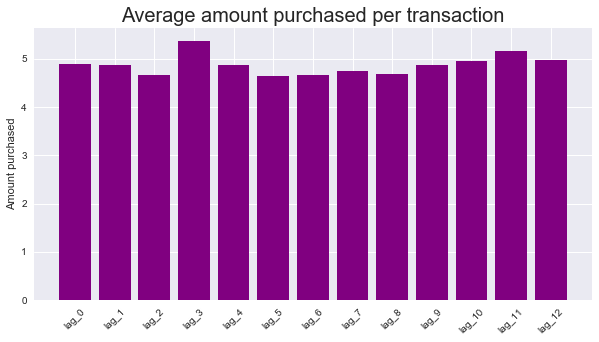

In [47]:
plt.figure(figsize = (10, 5))
plt.bar(np.arange(len(ave_amount_block)),ave_amount_block.values, color = 'purple')
plt.xticks(np.arange(len(ave_amount_block)),ave_amount_block.index, rotation = 45)
plt.ylabel('Amount purchased')
plt.title('Average amount purchased per transaction', fontsize = 20)

In [48]:
total_quantity_block = transaction.groupby(['dateblock']).purchasequantity.sum()
total_amount_block = transaction.groupby(['dateblock']).purchaseamount.sum()

In [49]:
total_quantity_block= total_quantity_block.reindex_axis([u'lag_0', u'lag_1', u'lag_2', u'lag_3', u'lag_4', u'lag_5',
       u'lag_6', u'lag_7', u'lag_8', u'lag_9', u'lag_10', u'lag_11', u'lag_12'], axis = 0)

In [50]:
total_amount_block= total_amount_block.reindex_axis([u'lag_0', u'lag_1', u'lag_2', u'lag_3', u'lag_4', u'lag_5',
       u'lag_6', u'lag_7', u'lag_8', u'lag_9', u'lag_10', u'lag_11', u'lag_12'], axis = 0)

Text(0.5,1,u'Total quantity purchased each month')

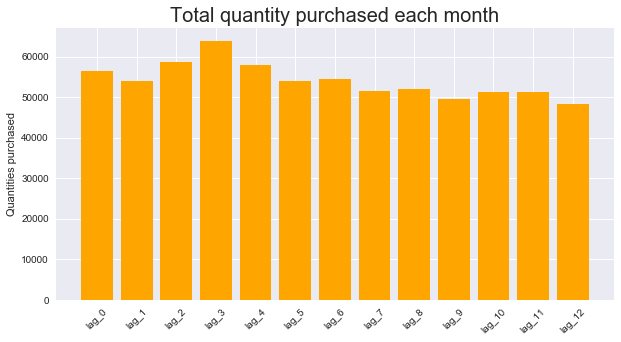

In [51]:
plt.figure(figsize = (10, 5))
plt.bar(np.arange(len(total_quantity_block)),total_quantity_block.values, color = 'orange')
plt.xticks(np.arange(len(total_quantity_block)),total_quantity_block.index, rotation = 45)
plt.ylabel('Quantities purchased')
plt.title('Total quantity purchased each month', fontsize = 20)

Text(0.5,1,u'Total amount purchased each month')

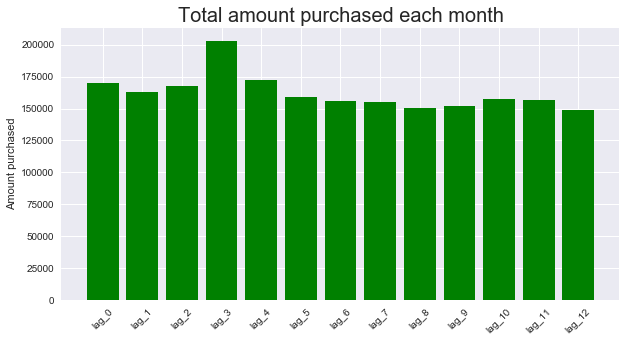

In [52]:
plt.figure(figsize = (10, 5))
plt.bar(np.arange(len(total_amount_block)),total_amount_block.values, color = 'green')
plt.xticks(np.arange(len(total_amount_block)),total_amount_block.index, rotation = 45)
plt.ylabel('Amount purchased')
plt.title('Total amount purchased each month', fontsize = 20)

### lag_3 has the highest total amount/quantity purchased. This month is December, a holiday month.

## Demand Forecasting of each item in each store:
### I want to build a forecasting model such that if I want to predict the demand in April 2013, I will use data from April 2012 to March 2013 (a whole year data before April 2013) to predict. By building the model, I have data from March 2012 to March 2013, which can be trained to build the model.

In [53]:
quantity_table = transaction.pivot_table(index = ['chain','company','brand','category','productsize','productmeasure'],
                                        columns = 'dateblock',
                                        values = 'purchasequantity',
                                        aggfunc = 'sum').fillna(0).reset_index()

In [54]:
quantity_table.head()

dateblock,chain,company,brand,category,productsize,productmeasure,lag_0,lag_1,lag_10,lag_11,lag_12,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9
0,2,10000,0,0,0.0,Unknown,1.0,0.0,1.0,0.0,1.0,0.0,0.0,5.0,0.0,3.0,0.0,0.0,0.0
1,2,10000,0,9753,1.0,CT,2.0,0.0,1.0,5.0,0.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0
2,2,1013313,52604,1841,1.0,CT,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,10100010,9907,1006,16.0,OZ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,10912898,46937,7901,1.0,CT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [55]:
features = ['chain','company','brand','category','productsize','productmeasure',
          'lag_12','lag_11','lag_10','lag_9','lag_8','lag_7','lag_6','lag_5','lag_4',
            'lag_3','lag_2','lag_1','lag_0']

In [56]:
quantity_table = quantity_table[features]

In [57]:
quantity_table.head()

dateblock,chain,company,brand,category,productsize,productmeasure,lag_12,lag_11,lag_10,lag_9,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,lag_0
0,2,10000,0,0,0.0,Unknown,1.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,1.0
1,2,10000,0,9753,1.0,CT,0.0,5.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,0.0,2.0
2,2,1013313,52604,1841,1.0,CT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2,10100010,9907,1006,16.0,OZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2,10912898,46937,7901,1.0,CT,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Now I want to adjust values in quantity table, so values in each lag_i corresponds to 30 days' value.The adjustment is done by multiplying the average value per day for each month by 30.

In [58]:
product_features = ['chain','company','brand','category','productsize','productmeasure']

In [59]:
quantity_adjusted_table = pd.DataFrame()
for feature in product_features:
    quantity_adjusted_table[feature] = quantity_table[feature]

In [60]:
quantity_adjusted_table

,chain,company,brand,category,productsize,productmeasure
0,2,10000,0,0,0.00,Unknown
1,2,10000,0,9753,1.00,CT
2,2,1013313,52604,1841,1.00,CT
3,2,10100010,9907,1006,16.00,OZ
4,2,10912898,46937,7901,1.00,CT
5,2,10930090,12157,2806,24.00,OZ
6,2,10980090,12851,1910,13.00,OZ
7,2,10980090,18366,427,1.00,OZ
8,2,101030010,5740,3315,7.50,OZ
9,2,101070010,7446,407,6.00,OZ


In [61]:
quantity_adjusted_table['lag_12_q'] = quantity_table['lag_12']/31*30
quantity_adjusted_table['lag_11_q'] = quantity_table['lag_11']
quantity_adjusted_table['lag_10_q'] = quantity_table['lag_10']/31*30
quantity_adjusted_table['lag_9_q'] = quantity_table['lag_9']
quantity_adjusted_table['lag_8_q'] = quantity_table['lag_8']/31*30
quantity_adjusted_table['lag_7_q'] = quantity_table['lag_7']/31*30
quantity_adjusted_table['lag_6_q'] = quantity_table['lag_6']
quantity_adjusted_table['lag_5_q'] = quantity_table['lag_5']/31*30
quantity_adjusted_table['lag_4_q'] = quantity_table['lag_4']
quantity_adjusted_table['lag_3_q'] = quantity_table['lag_3']/31*30
quantity_adjusted_table['lag_2_q'] = quantity_table['lag_2']/31*30
quantity_adjusted_table['lag_1_q'] = quantity_table['lag_1']
quantity_adjusted_table['lag_0_q'] = quantity_table['lag_0']/31*30

In [62]:
quantity_adjusted_table.head()

,chain,company,brand,category,productsize,productmeasure,lag_12_q,lag_11_q,lag_10_q,lag_9_q,lag_8_q,lag_7_q,lag_6_q,lag_5_q,lag_4_q,lag_3_q,lag_2_q,lag_1_q,lag_0_q
0,2,10000,0,0,0.0,Unknown,0.967742,0.0,0.967742,0.0,0.000000,0.000000,3.0,0.000000,5.0,0.000000,0.000000,0.0,0.967742
1,2,10000,0,9753,1.0,CT,0.000000,5.0,0.967742,1.0,1.935484,0.967742,1.0,0.967742,2.0,1.935484,1.935484,0.0,1.935484
2,2,1013313,52604,1841,1.0,CT,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.967742,0.000000,0.0,0.000000
3,2,10100010,9907,1006,16.0,OZ,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.967742,0.0,0.000000
4,2,10912898,46937,7901,1.0,CT,0.000000,0.0,0.000000,0.0,0.000000,0.967742,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000


### I also want to add price information in final modeling. As demand also depends on prices.

In [63]:
price_table = transaction.pivot_table(index = ['chain','company','brand','category','productsize','productmeasure'],
                                        columns = 'dateblock',
                                        values = 'price',
                                        aggfunc = 'mean').fillna(0).reset_index()

In [64]:
price_table.head()

dateblock,chain,company,brand,category,productsize,productmeasure,lag_0,lag_1,lag_10,lag_11,lag_12,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9
0,2,10000,0,0,0.0,Unknown,5.99,0.0,2.50,0.00,5.39,0.00,0.00,1.5625,0.0,2.2475,0.00,0.00,0.00
1,2,10000,0,9753,1.0,CT,0.99,0.0,0.69,0.93,0.00,5.65,1.21,4.0050,3.4,0.9900,0.99,0.74,0.99
2,2,1013313,52604,1841,1.0,CT,0.00,0.0,0.00,0.00,0.00,0.00,29.99,0.0000,0.0,0.0000,0.00,0.00,0.00
3,2,10100010,9907,1006,16.0,OZ,0.00,0.0,0.00,0.00,0.00,3.29,0.00,0.0000,0.0,0.0000,0.00,0.00,0.00
4,2,10912898,46937,7901,1.0,CT,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0000,0.0,0.0000,5.99,0.00,0.00


In [65]:
features = ['chain','company','brand','category','productsize','productmeasure',
          'lag_12','lag_11','lag_10','lag_9','lag_8','lag_7','lag_6','lag_5','lag_4',
            'lag_3','lag_2','lag_1','lag_0']

In [66]:
price_table = price_table[features]

In [67]:
price_table.head()

dateblock,chain,company,brand,category,productsize,productmeasure,lag_12,lag_11,lag_10,lag_9,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,lag_0
0,2,10000,0,0,0.0,Unknown,5.39,0.00,2.50,0.00,0.00,0.00,2.2475,0.0,1.5625,0.00,0.00,0.0,5.99
1,2,10000,0,9753,1.0,CT,0.00,0.93,0.69,0.99,0.74,0.99,0.9900,3.4,4.0050,1.21,5.65,0.0,0.99
2,2,1013313,52604,1841,1.0,CT,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,0.0,0.0000,29.99,0.00,0.0,0.00
3,2,10100010,9907,1006,16.0,OZ,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,0.0,0.0000,0.00,3.29,0.0,0.00
4,2,10912898,46937,7901,1.0,CT,0.00,0.00,0.00,0.00,0.00,5.99,0.0000,0.0,0.0000,0.00,0.00,0.0,0.00


In [68]:
price_table = price_table.rename(columns = {'lag_0': 'lag_0_p',
                                             'lag_1': 'lag_1_p',
                                             'lag_2': 'lag_2_p',
                                             'lag_3': 'lag_3_p',
                                             'lag_4': 'lag_4_p',
                                             'lag_5': 'lag_5_p',
                                             'lag_6': 'lag_6_p',
                                             'lag_7': 'lag_7_p',
                                             'lag_8': 'lag_8_p',
                                             'lag_9': 'lag_9_p',
                                             'lag_10': 'lag_10_p',
                                             'lag_11': 'lag_11_p',
                                             'lag_12': 'lag_12_p'})

In [69]:
price_table.head()

dateblock,chain,company,brand,category,productsize,productmeasure,lag_12_p,lag_11_p,lag_10_p,lag_9_p,lag_8_p,lag_7_p,lag_6_p,lag_5_p,lag_4_p,lag_3_p,lag_2_p,lag_1_p,lag_0_p
0,2,10000,0,0,0.0,Unknown,5.39,0.00,2.50,0.00,0.00,0.00,2.2475,0.0,1.5625,0.00,0.00,0.0,5.99
1,2,10000,0,9753,1.0,CT,0.00,0.93,0.69,0.99,0.74,0.99,0.9900,3.4,4.0050,1.21,5.65,0.0,0.99
2,2,1013313,52604,1841,1.0,CT,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,0.0,0.0000,29.99,0.00,0.0,0.00
3,2,10100010,9907,1006,16.0,OZ,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,0.0,0.0000,0.00,3.29,0.0,0.00
4,2,10912898,46937,7901,1.0,CT,0.00,0.00,0.00,0.00,0.00,5.99,0.0000,0.0,0.0000,0.00,0.00,0.0,0.00


In [70]:
data_table = price_table.join(quantity_adjusted_table.loc[:,'lag_12_q':'lag_0_q'])

In [71]:
data_table.head()

,chain,company,brand,category,productsize,productmeasure,lag_12_p,lag_11_p,lag_10_p,lag_9_p,...,lag_9_q,lag_8_q,lag_7_q,lag_6_q,lag_5_q,lag_4_q,lag_3_q,lag_2_q,lag_1_q,lag_0_q
0,2,10000,0,0,0.0,Unknown,5.39,0.00,2.50,0.00,...,0.0,0.000000,0.000000,3.0,0.000000,5.0,0.000000,0.000000,0.0,0.967742
1,2,10000,0,9753,1.0,CT,0.00,0.93,0.69,0.99,...,1.0,1.935484,0.967742,1.0,0.967742,2.0,1.935484,1.935484,0.0,1.935484
2,2,1013313,52604,1841,1.0,CT,0.00,0.00,0.00,0.00,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.967742,0.000000,0.0,0.000000
3,2,10100010,9907,1006,16.0,OZ,0.00,0.00,0.00,0.00,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.967742,0.0,0.000000
4,2,10912898,46937,7901,1.0,CT,0.00,0.00,0.00,0.00,...,0.0,0.000000,0.967742,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000


In [72]:
data_table.iloc[:,6:].head()

,lag_12_p,lag_11_p,lag_10_p,lag_9_p,lag_8_p,lag_7_p,lag_6_p,lag_5_p,lag_4_p,lag_3_p,...,lag_9_q,lag_8_q,lag_7_q,lag_6_q,lag_5_q,lag_4_q,lag_3_q,lag_2_q,lag_1_q,lag_0_q
0,5.39,0.00,2.50,0.00,0.00,0.00,2.2475,0.0,1.5625,0.00,...,0.0,0.000000,0.000000,3.0,0.000000,5.0,0.000000,0.000000,0.0,0.967742
1,0.00,0.93,0.69,0.99,0.74,0.99,0.9900,3.4,4.0050,1.21,...,1.0,1.935484,0.967742,1.0,0.967742,2.0,1.935484,1.935484,0.0,1.935484
2,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,0.0,0.0000,29.99,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.967742,0.000000,0.0,0.000000
3,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,0.0,0.0000,0.00,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.967742,0.0,0.000000
4,0.00,0.00,0.00,0.00,0.00,5.99,0.0000,0.0,0.0000,0.00,...,0.0,0.000000,0.967742,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000


In [73]:
#encode label 'productmeasure'
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_table['productmeasure'] = le.fit_transform(data_table['productmeasure'])

In [74]:
data_table['lag_0_p'].describe()

count    216582.000000
mean          0.491423
std           1.963103
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         288.750000
Name: lag_0_p, dtype: float64

In [75]:
data_table['lag_0_q'].describe()

count    216582.000000
mean          0.252040
std           4.180196
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1685.806452
Name: lag_0_q, dtype: float64

In [76]:
len(data_table[data_table['lag_0_q'] == 0])

187260

In [77]:
float(len(data_table[data_table['lag_0_q'] == 0]))/len(data_table)

0.8646147879325151

In [78]:
len(data_table[data_table['lag_1_q'] == 0])

188306

In [79]:
float(len(data_table[data_table['lag_1_q'] == 0]))/len(data_table)

0.8694443674912966

In [80]:
zero_quantity_percent = 0
for i in range(13):
    zero_quantity_percent += float(len(data_table[data_table['lag_{}_q'.format(i)] == 0]))/len(data_table)
zero_quantity_percent / 13    

0.8713349287496723

### This shows on average 87% of the products in each store have demand 0 each month. 

### Check outliers in the data table.

In [81]:
len(data_table)

216582

In [82]:
outlier_greater_than_ten_sum = 0
for i in range(12):
    outlier_greater_than_ten_sum += len(data_table[data_table['lag_{}_q'.format(i+1)] > 10])
outlier_greater_than_ten_ave = outlier_greater_than_ten_sum / 12
outlier_greater_than_ten_ave

328

In [83]:
outlier_greater_than_five_sum = 0
for i in range(12):
    outlier_greater_than_five_sum += len(data_table[data_table['lag_{}_q'.format(i+1)] > 5])
outlier_greater_than_five_ave = outlier_greater_than_five_sum / 12
outlier_greater_than_five_ave

1056

In [84]:
outlier_greater_than_three_sum = 0
for i in range(12):
    outlier_greater_than_three_sum += len(data_table[data_table['lag_{}_q'.format(i+1)] > 3])
outlier_greater_than_three_ave = outlier_greater_than_three_sum / 12
outlier_greater_than_three_ave

2371

In [85]:
float(outlier_greater_than_ten_ave) / len(data_table)

0.0015144379495987664

In [86]:
float(outlier_greater_than_five_ave) / len(data_table)

0.004875751447488711

In [87]:
float(outlier_greater_than_three_ave) / len(data_table)

0.01094735481249596

### This shows on average 0.15% of the product in each store have demand greater than 10 each month, 0.49% of the product in each store have demand greater than 5 each month, and 1.09% of the product in each store in each store have demand greater than 3 each month.

### Building models: we know the current price and previous prices, previous demand, now want to predict current demand. This is how I approach the forecasting problem: The current demand depends on current price, previous prices and previous demand.

### First of all, I build models using demand data from  March 2012 to Jan 2013, price data from March 2012 to Feb 2013, train on those data and validate the model on demand Feb 2013. Then I use the model and price data March 2013 to predict demand in March 2013. Since I have real demand data in March 2013, I can see how my model works.
### Suppose we don't know lag_0_q and lag_0_p (for modeling purpose, I want to test how my model works, so I assume I don't know the demand in March 2013). We want to train on lag_12_q,...,lag_2_q and lag_12_p,..., lag_1_p and predict on lag_1_q. Then we use the model and lag_0_p to predict on lag_0_q.

In [100]:
import xgboost as xgb

In [89]:
data_table.iloc[:,18:19].head()  # need  to remove column 18

,lag_0_p
0,5.99
1,0.99
2,0.00
3,0.00
4,0.00


In [90]:
data_train_table = data_table.iloc[:,6:18].join(data_table.iloc[:,19:-1])
data_train_table.head()

,lag_12_p,lag_11_p,lag_10_p,lag_9_p,lag_8_p,lag_7_p,lag_6_p,lag_5_p,lag_4_p,lag_3_p,...,lag_10_q,lag_9_q,lag_8_q,lag_7_q,lag_6_q,lag_5_q,lag_4_q,lag_3_q,lag_2_q,lag_1_q
0,5.39,0.00,2.50,0.00,0.00,0.00,2.2475,0.0,1.5625,0.00,...,0.967742,0.0,0.000000,0.000000,3.0,0.000000,5.0,0.000000,0.000000,0.0
1,0.00,0.93,0.69,0.99,0.74,0.99,0.9900,3.4,4.0050,1.21,...,0.967742,1.0,1.935484,0.967742,1.0,0.967742,2.0,1.935484,1.935484,0.0
2,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,0.0,0.0000,29.99,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.967742,0.000000,0.0
3,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,0.0,0.0000,0.00,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.967742,0.0
4,0.00,0.00,0.00,0.00,0.00,5.99,0.0000,0.0,0.0000,0.00,...,0.000000,0.0,0.000000,0.967742,0.0,0.000000,0.0,0.000000,0.000000,0.0


In [107]:
X = data_train_table.iloc[:,:-1].values
y = data_train_table.iloc[:,-1].values

In [108]:
X_train, X_vali, y_train, y_vali = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Use XGBoost Regressor

In [109]:
xgb_1 = xgb.XGBRegressor(objective = 'reg:linear',
                        max_depth = 12,
                        subsample = 0.9,
                        colsample_bytree = 0.9,
                        min_child_weight = 0.5,
                        learning_rate = 0.1,
                        seed = 0,
                        silent = 0)

In [110]:
xgb_1.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=12,
       min_child_weight=0.5, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=0, subsample=0.9)

In [111]:
y_1_pred_train = xgb_1.predict(X_train)
xgb_1_mse_train = mean_squared_error(y_1_pred_train, y_train)
print ("Train data RMSE", np.sqrt(xgb_1_mse_train))

('Train data RMSE', 1.6565591744121766)


In [112]:
# Validate the data
y_1_pred_validate = xgb_1.predict(X_vali)
xgb_1_mse_validate = mean_squared_error(y_1_pred_validate, y_vali)
print("Validation-data_quantity RMSE", np.sqrt(xgb_1_mse_validate))  

('Validation-data_quantity RMSE', 2.0091586126377812)


In [113]:
xgb_1.fit(X,y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=12,
       min_child_weight=0.5, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=0, subsample=0.9)

In [114]:
data_table.iloc[:,19:20].head()

,lag_12_q
0,0.967742
1,0.000000
2,0.000000
3,0.000000
4,0.000000


In [115]:
data_test_table = data_table.iloc[:,7:19].join(data_table.iloc[:,20:])
data_test_table.head()

,lag_11_p,lag_10_p,lag_9_p,lag_8_p,lag_7_p,lag_6_p,lag_5_p,lag_4_p,lag_3_p,lag_2_p,...,lag_9_q,lag_8_q,lag_7_q,lag_6_q,lag_5_q,lag_4_q,lag_3_q,lag_2_q,lag_1_q,lag_0_q
0,0.00,2.50,0.00,0.00,0.00,2.2475,0.0,1.5625,0.00,0.00,...,0.0,0.000000,0.000000,3.0,0.000000,5.0,0.000000,0.000000,0.0,0.967742
1,0.93,0.69,0.99,0.74,0.99,0.9900,3.4,4.0050,1.21,5.65,...,1.0,1.935484,0.967742,1.0,0.967742,2.0,1.935484,1.935484,0.0,1.935484
2,0.00,0.00,0.00,0.00,0.00,0.0000,0.0,0.0000,29.99,0.00,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.967742,0.000000,0.0,0.000000
3,0.00,0.00,0.00,0.00,0.00,0.0000,0.0,0.0000,0.00,3.29,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.967742,0.0,0.000000
4,0.00,0.00,0.00,0.00,5.99,0.0000,0.0,0.0000,0.00,0.00,...,0.0,0.000000,0.967742,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000


In [116]:
X_test = data_test_table.iloc[:,0:-1].values
y_test = data_test_table.iloc[:,-1].values

## We want to have some idea what real values of demand in March 2013 looks like.

In [175]:
data_test_table.iloc[:,-1].describe()

count    216582.000000
mean          0.252040
std           4.180196
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1685.806452
Name: lag_0_q, dtype: float64

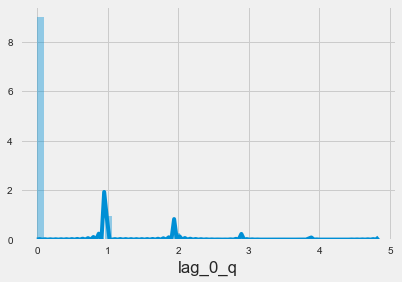

In [172]:
sns.distplot(data_test_table[data_test_table['lag_0_q']<5].lag_0_q)

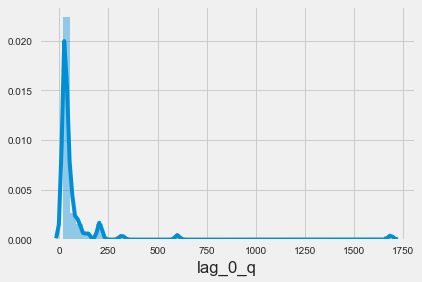

In [170]:
sns.distplot(data_test_table[data_test_table['lag_0_q']>20].lag_0_q)

In [117]:
# Validate the data
y_1_pred_test = xgb_1.predict(X_test)
xgb_1_mse_test = mean_squared_error(y_1_pred_test, y_test)
print("Test data RMSE", np.sqrt(xgb_1_mse_test))   # 4.1225932356108901

('Test data RMSE', 4.1225932356108901)


### RandomForest Regressor

In [118]:
from sklearn.ensemble import RandomForestRegressor

In [119]:
rf_1 = RandomForestRegressor(n_estimators = 50, max_depth = 50,
                            max_features = 'sqrt',
                            min_samples_split = 10,
                            min_samples_leaf = 1,
                            random_state = 42)

In [120]:
rf_1.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [121]:
y_2_pred_train = rf_1.predict(X_train)
rf_1_mse_train = mean_squared_error(y_2_pred_train, y_train)
print ("Train data RMSE", np.sqrt(rf_1_mse_train))

('Train data RMSE', 1.8498688804839485)


In [122]:
# Validate the data
y_2_pred_validate = rf_1.predict(X_vali)
rf_1_mse_validate = mean_squared_error(y_2_pred_validate, y_vali)
print("Validation-data_quantity RMSE", np.sqrt(rf_1_mse_validate))  

('Validation-data_quantity RMSE', 1.7166649507068588)


In [123]:
rf_1.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [125]:
# Test the data
y_2_pred_test = rf_1.predict(X_test)
rf_1_mse_test = mean_squared_error(y_2_pred_test, y_test)
print("Test data RMSE", np.sqrt(rf_1_mse_test))  # 4.1217321176442416

('Test data RMSE', 4.1217321176442416)


### Use neural network

In [126]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [127]:
nn_1 = Sequential()
nn_1.add(Dense(8, input_dim = len(data_train_table.iloc[:,:-1].columns), activation = 'relu'))
nn_1.add(Dense(8, activation = 'relu'))
nn_1.add(Dense(1, activation = 'linear'))
nn_1.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [128]:
nn_1.fit(X_train, y_train, epochs = 100, verbose = 0)

In [129]:
y_3_pred_train = nn_1.predict(X_train)

In [130]:
nn_1_mse_train = mean_squared_error(y_3_pred_train, y_train)
print ("Train data RMSE", np.sqrt(nn_1_mse_train))

('Train data RMSE', 2.1508592273123686)


In [131]:
y_3_pred_validate = nn_1.predict(X_vali)

In [133]:
nn_1_mse_validate = mean_squared_error(y_3_pred_validate, y_vali)
print ("Validate data RMSE", np.sqrt(nn_1_mse_validate))

('Validate data RMSE', 1.6167286768353721)


In [134]:
nn_1.fit(X, y, epochs = 100, verbose = 0)

In [135]:
y_4_pred_test = nn_1.predict(X_test)

In [136]:
nn_1_mse_test = mean_squared_error(y_4_pred_test, y_test)
print ("Test data RMSE", np.sqrt(nn_1_mse_test))   # 4.112976661278795

('Test data RMSE', 4.112976661278795)


### RandomForest is a good estimator. I will do grid search using RandomForest model.

In [138]:
from sklearn.model_selection import GridSearchCV

In [139]:
param_1 = {
    'n_estimators': [20, 50, 80],
    'max_features':['auto','sqrt','log2',None]
}

In [140]:
rf = RandomForestRegressor(n_estimators = 50, max_depth = 50,
                            max_features = 'sqrt',
                            min_samples_split = 10,
                            min_samples_leaf = 1,
                            random_state = 42)

In [141]:
rf_grid_1 = GridSearchCV(rf, param_1, scoring = 'neg_mean_squared_error',cv = 3)

In [142]:
rf_grid_1.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [20, 50, 80], 'max_features': ['auto', 'sqrt', 'log2', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [143]:
print rf_grid_1.best_score_, rf_grid_1.best_params_ 

-4.9022547672 {'max_features': 'sqrt', 'n_estimators': 80}


In [144]:
rf_2 = RandomForestRegressor(n_estimators = 80, max_depth = 50,
                            max_features = 'sqrt',
                            min_samples_split = 10,
                            min_samples_leaf = 1,
                            random_state = 42)

In [146]:
# Test the data
rf_2.fit(X, y)
y_5_pred_test = rf_2.predict(X_test)
rf_2_mse_test = mean_squared_error(y_5_pred_test, y_test)
print("Test data RMSE", np.sqrt(rf_2_mse_test))  # 4.1161460730516053

('Test data RMSE', 4.1161460730516053)


In [147]:
param_2 = {
    'max_depth': [10,20,50,80],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 10]
}

In [148]:
rf_grid_2 = GridSearchCV(rf_2, param_2, scoring = 'neg_mean_squared_error',cv = 3)

In [149]:
rf_grid_2.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=80, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 5, 10], 'max_depth': [10, 20, 50, 80], 'min_samples_leaf': [1, 2, 4, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [150]:
print rf_grid_2.best_score_, rf_grid_2.best_params_ 

-4.72066745909 {'min_samples_split': 2, 'max_depth': 10, 'min_samples_leaf': 2}


In [151]:
rf_3 = RandomForestRegressor(n_estimators = 80, max_depth = 10,
                            max_features = 'sqrt',
                            min_samples_split = 2,
                            min_samples_leaf = 2,
                            random_state = 42)

In [152]:
rf_3.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=80, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [153]:
# Test the data
y_6_pred_test = rf_3.predict(X_test)
rf_3_mse_test = mean_squared_error(y_6_pred_test, y_test)
print("Test data RMSE", np.sqrt(rf_3_mse_test))  # 4.1040812273190106

('Test data RMSE', 4.1040812273190106)


In [189]:
data_train_table.iloc[:,-1].describe()  
#take a look at the demand of the most recent month in training set

count    216582.000000
mean          0.249716
std           2.329625
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         629.000000
Name: lag_1_q, dtype: float64

### We want to convert our predictions into integers. Considering the adjustment of demand in 30 days, we want to consider the demand in 31 days (since the month we want to predict is March 2013).

In [199]:
best_prediction = pd.DataFrame({'prediction': y_6_pred_test/30*31})
best_prediction.describe()

,prediction
count,216582.000000
mean,0.263064
std,0.828917
min,0.020111
25%,0.040997
50%,0.044392
75%,0.045981
max,115.831039


In [198]:
real_value = pd.DataFrame({'real values': y_test/30*31})
real_value.describe()

,real values
count,216582.000000
mean,0.260442
std,4.319536
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1742.000000


### Our predictions result from machine learning modeling is just slightly better than taking average of the most recent demand.

In [204]:
import math

In [210]:
math.ceil(115.81039)

116.0

In [211]:
y_test_adjusted = y_test/30*31      

In [245]:
y_mean_zero = [0]*len(y_test)

In [246]:
np.sqrt(mean_squared_error(y_mean_zero, y_test/30*31))  # 4.3273700375785724
## our predictions results from modeling is just slightly better than taking average of the most recent demand.

4.3273700375785724

In [247]:
y_mean_ones = [1]*len(y_test)

In [248]:
np.sqrt(mean_squared_error(y_mean_ones, y_test/30*31))  # 4.3823792506891124
## our predictions results from modeling is just slightly better than taking average of the most recent demand.

4.3823792506891124

In [235]:
y_pred_adjusted = []
for i in range(len(y_6_pred_test)):
    y_pred_adjusted.append(round(y_6_pred_test[i]/30*31))

In [236]:
prediction_adjusted = pd.DataFrame({'prediction adjusted': y_pred_adjusted})
prediction_adjusted.describe()

,prediction adjusted
count,216582.000000
mean,0.199499
std,0.818678
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,116.000000


In [238]:
np.sqrt(mean_squared_error(y_pred_adjusted, y_test_adjusted)) #4.243388814932854

4.243388814932854

In [249]:
4.243388814932854/4.3823792506891124

0.9682842520454151

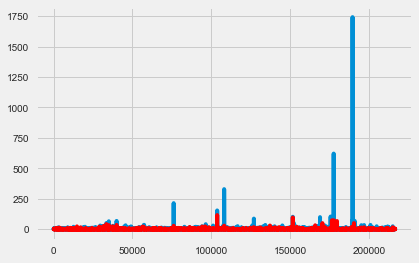

In [250]:
plt.plot(y_test_adjusted)
plt.plot(y_pred_adjusted, color = 'red')
plt.show()

In [274]:
count_1 = 0 
count_5 = 0
count_10 = 0
count_20 = 0
count_50 = 0
count_100 = 0
for i in range(len(y_pred_adjusted)):
    if y_pred_adjusted[i] >= 1:
        count_1 += 1
    if y_pred_adjusted[i] >= 5:
        count_5 += 1
    if y_pred_adjusted[i] >= 10:
        count_10 += 1
    if y_pred_adjusted[i] >= 20:
        count_20 += 1
    if y_pred_adjusted[i] >= 50:
        count_50 += 1
    if y_pred_adjusted[i] >= 100:
        count_100 += 1
print count_1, count_5, count_10, count_20, count_50, count_100

29613 548 140 32 7 1


In [275]:
count_1 = 0
count_5 = 0
count_10 = 0
count_20 = 0
count_50 = 0
count_100 = 0
for i in range(len(y_test_adjusted)):
    if y_test_adjusted[i] >= 1:
        count_1 += 1
    if y_test_adjusted[i] >= 5:
        count_5 += 1
    if y_test_adjusted[i] >= 10:
        count_10 += 1
    if y_test_adjusted[i] >= 20:
        count_20 += 1
    if y_test_adjusted[i] >= 50:
        count_50 += 1
    if y_test_adjusted[i] >= 100:
        count_100 += 1
print count_1, count_5, count_10, count_20, count_50, count_100

29322 1469 371 92 25 12


In [253]:
count_true_zeros = 0
for i in range(len(y_test_adjusted)):
    if y_test_adjusted[i] == 0 and y_pred_adjusted[i] == 0:
        count_true_zeros += 1
print count_true_zeros

186969


In [276]:
count_true_nonzeros = 0
for i in range(len(y_test_adjusted)):
    if y_test_adjusted[i] > 0 and y_pred_adjusted[i] > 0:
        count_true_nonzeros += 1
print count_true_nonzeros

29322


In [285]:
count_true_fives = 0
for i in range(len(y_test_adjusted)):
    if y_test_adjusted[i] >= 5 and y_pred_adjusted[i] >= 5:
        count_true_fives += 1
print count_true_fives

296


In [286]:
count_true_tens = 0
for i in range(len(y_test_adjusted)):
    if y_test_adjusted[i] >= 10 and y_pred_adjusted[i] >= 10:
        count_true_tens += 1
print count_true_tens

64


In [277]:
count_0 = 0
for i in range(len(y_test_adjusted)):
    if y_test_adjusted[i] == 0:
        count_0 += 1
print count_0

187260


In [278]:
count_0 = 0
for i in range(len(y_pred_adjusted)):
    if y_pred_adjusted[i] == 0:
        count_0 += 1
print count_0

186969


In [279]:
len(y_test_adjusted)  # number of data

216582

In [280]:
float(187260)/216582   # zero demand percentage in real values

0.8646147879325151

In [283]:
float(186969) / 187260  # percentage of correctly predicted zero demand

0.9984460108939442

In [284]:
29322 / 29322 # percentage of correctly predicted nonzero demand

1

In [296]:
y_test_positive = []
y_pred_positive = []
for i in range(len(y_test_adjusted)):
    if y_test_adjusted[i] > 0:
        y_test_positive.append(y_test_adjusted[i])
        y_pred_positive.append(y_pred_adjusted[i])
print np.sqrt(mean_squared_error(y_test_positive, y_pred_positive))

11.497094113


In [303]:
print max(y_test_positive), min(y_test_positive), sum(y_test_positive)/float(len(y_test_positive)),np.std(y_test_positive)

 1742.0 1.0 1.92370916036 11.6024458539


In [306]:
print max(y_pred_positive), min(y_pred_positive),sum(y_pred_positive)/float(len(y_pred_positive)), np.std(y_pred_positive)

116.0 1.0 1.44273924016 1.5314536301


In [308]:
np.sqrt(mean_squared_error([1.92370916036]*len(y_test_positive),y_test_positive ))

11.602445853856965

In [310]:
len(y_test_positive)

29322

### As we can compare from prediction and true values, the reason that RMSE of our predictions is not significantly better than RMSE of taking the smallest integer greater than the mean of previous demand, or simply the RMSE of assuming zero demand for all products is that our modeling cannot predict unusal large values. The unusal sales with large values can be random, hence is unexpected and hard to predict.
### However in our model we are able to correct predict the zero demand products.

### Now I plot the feature importances of the Random Forest model.

In [287]:
best_rf_model = rf_3.fit(X,y)

In [288]:
def plot_top_importance(model):
    plt.style.use('fivethirtyeight')
    ax = pd.DataFrame({'importance': model.feature_importances_},
                     index = data_train_table.iloc[:,0:-1].columns).sort_values('importance',
                     ascending = True).tail(10).plot(kind = 'barh', legend = False,
                                                    figsize = (20, 10),
                                                    fontsize = 17,
                                                    title = 'Top 10 most important features')
    ax.tick_params(axis = 'x', colors = 'pink')
    ax.tick_params(axis = 'y', colors = 'blue')
    plt.tight_layout()

In [289]:
def plot_least_importance(model):
    plt.style.use('fivethirtyeight')
    ax = pd.DataFrame({'importance': model.feature_importances_},
                     index = data_train_table.iloc[:,0:-1].columns).sort_values('importance',
                     ascending = False).tail(10).plot(kind = 'barh', legend = False,
                                                    figsize = (20, 10),
                                                    fontsize = 17,
                                                    title = 'Top 10 least important features')
    ax.tick_params(axis = 'x', colors = 'pink')
    ax.tick_params(axis = 'y', colors = 'blue')
    plt.tight_layout()

### By observing feature importance, we found that the current price, demand 11 months ago, demand 5 months ago and demand 1 month ago are most important features in predicting current demand. Those demand values correspond to current month's coming month(a year ago)'s demand, half a year's ago's demand, previous month's demand.

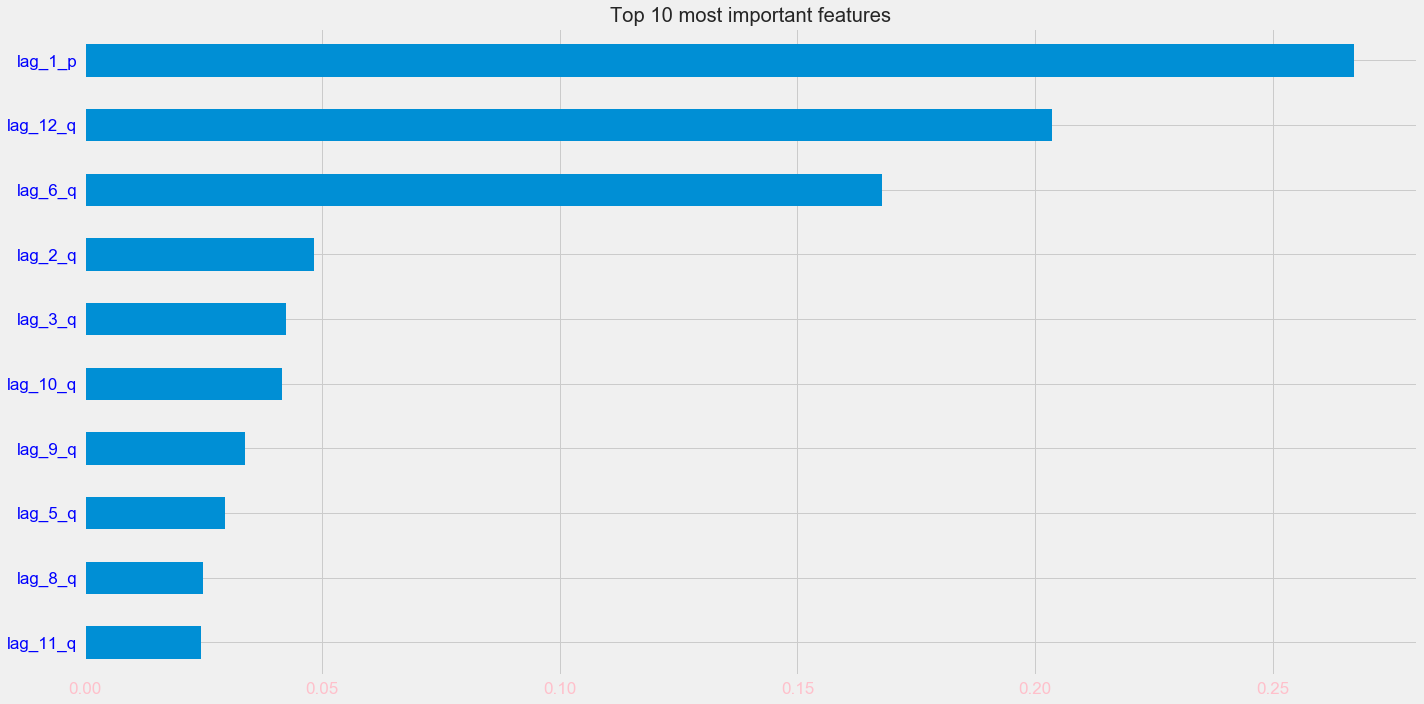

In [290]:
plot_top_importance(best_rf_model)

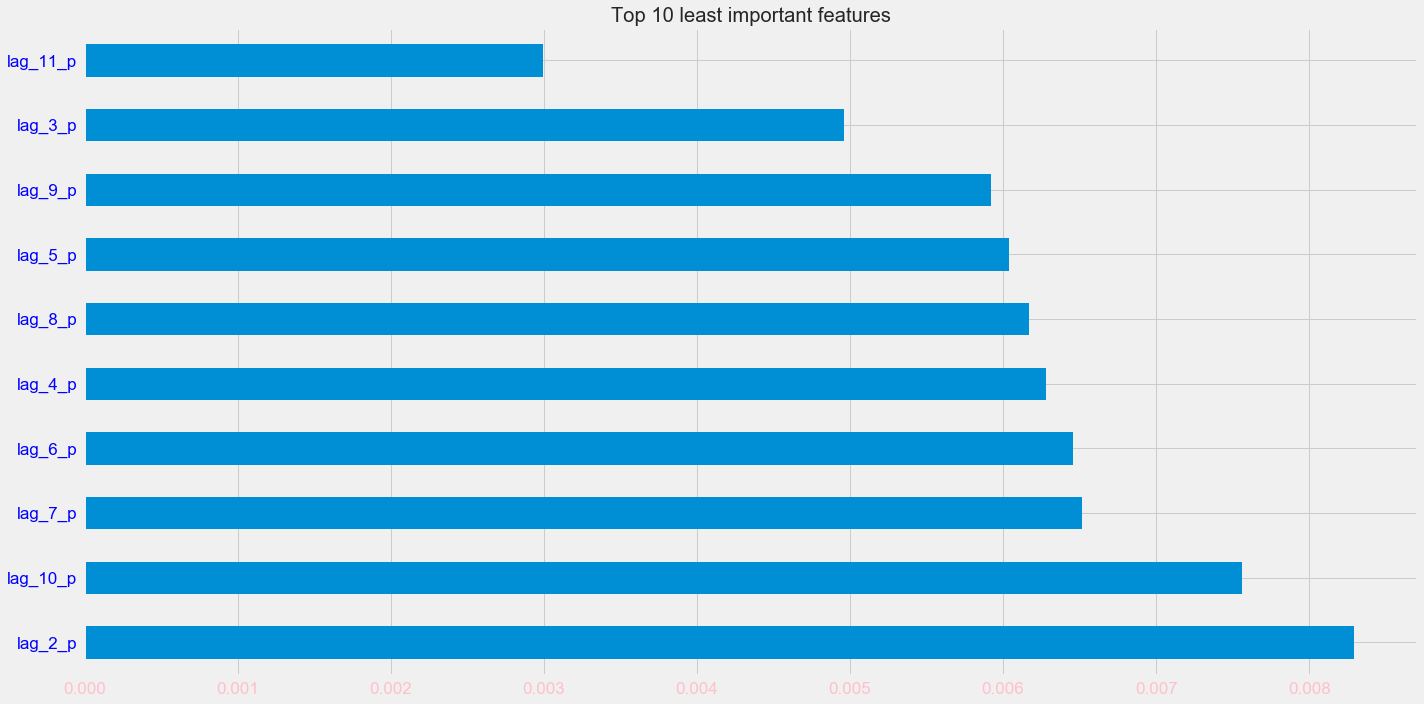

In [291]:
plot_least_importance(best_rf_model)

### If we just include the most recent price information.

In [292]:
X_smaller = data_train_table.iloc[:,11:-1].values

In [293]:
X_test_smaller = data_test_table.iloc[:,11:-1].values

In [294]:
best_rf_model = rf_3.fit(X_smaller,y)

In [295]:
# Test the data
y_7_pred_test = best_rf_model.predict(X_test_smaller)
best_rf_mse_test = mean_squared_error(y_7_pred_test, y_test)
print("Test data RMSE", np.sqrt(best_rf_mse_test))   #4.104518302404065

('Test data RMSE', 4.104518302404065)


### This shows reducing number of features does not help improve the prediction.